# Realizar un embedding para el campo text y visualizarlo con alguna técnica de reducción de visualizaciones distinta a PCA. En base a la visualización, ¿Sería posible predecir el target con este embedding?

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
# ! pip install umap-learn
import umap.umap_ as umap

DATA_DIR = Path('../data/nlp-getting-started')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
RANDOM_SEED = 27

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# 1. Separar features y target
X = train_df['text'].fillna('').copy()
y = train_df['target'].copy()

# 2. Split estratificado train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_train.head()

2025-11-20 16:04:30.970674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 16:04:31.004956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 16:04:32.113988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2721    Obama declares disaster for typhoon-devastated...
2259    Businesses are deluged with invzices. Make you...
1815    Neil_Eastwood77: I AM A KNOBHEAD!! Bin Laden f...
682     Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...
7216    @danagould @WaynesterAtl I agree with backgrou...
Name: text, dtype: object

In [2]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=6666, # Para mi xgboost fue el mejor 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english'
)

X_text = tfidf_vectorizer.fit_transform(train_df['text'].fillna(''))
y = train_df['target'].values

X_text.shape

(7613, 6666)

Ahora que tenemos la matriz TF-IDF, podemos aplicar UMAP para bajar a 2 dimensiones. La perdida de información va a ser brutal, pero es la única manera de visualizarlo en 2D.

In [3]:
umap_direct = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",  
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=True
)

X_umap_direct_2d = umap_direct.fit_transform(X_text)

/home/mate/FIUBA/ciencia-de-datos/tweet-checker/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=27, verbose=True)
Thu Nov 20 16:04:33 2025 Construct fuzzy simplicial set
Thu Nov 20 16:04:33 2025 Finding Nearest Neighbors
Thu Nov 20 16:04:33 2025 Building RP forest with 9 trees
Thu Nov 20 16:04:37 2025 metric NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	 9  /  13
	 10  /  13
	 11  /  13
	Stopping threshold met -- exiting after 11 iterations
Thu Nov 20 16:04:45 2025 Finished Nearest Neighbor Search
Thu Nov 20 16:04:47 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Nov 20 16:04:52 2025 Finished embedding


Okey! La reducción de dimensionalidad nos dió 3 dimensiones, que era lo que quería.

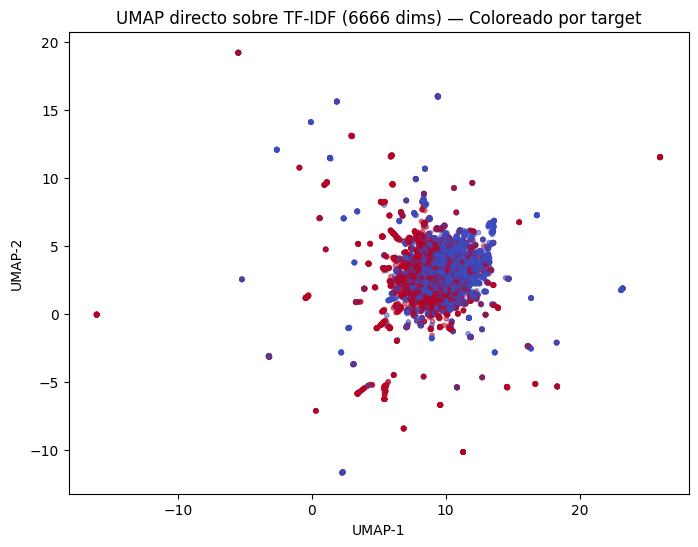

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_direct_2d[:, 0],
    X_umap_direct_2d[:, 1],
    c=y,
    cmap='coolwarm',
    alpha=0.5,
    s=10
)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP directo sobre TF-IDF (6666 dims) — Coloreado por target")
plt.show()


## Predicción del Target:

Bueno, a decir verdad no se ve tan mal. No hay clusters bastante definidos, pero podemos notar una leve distinción entre derecha e izquierda entre ambos. Definitivamente podríamos hacer un modelo muy pobre no supervisado que nos separe entre ambos, pero sería malísimo. Elegí K-Means porque te deja determinar la cantidad de clusters que querés, y en este caso sabemos que son 2 (derecha e izquierda).


F1 usando clusters como predicción: 0.4995


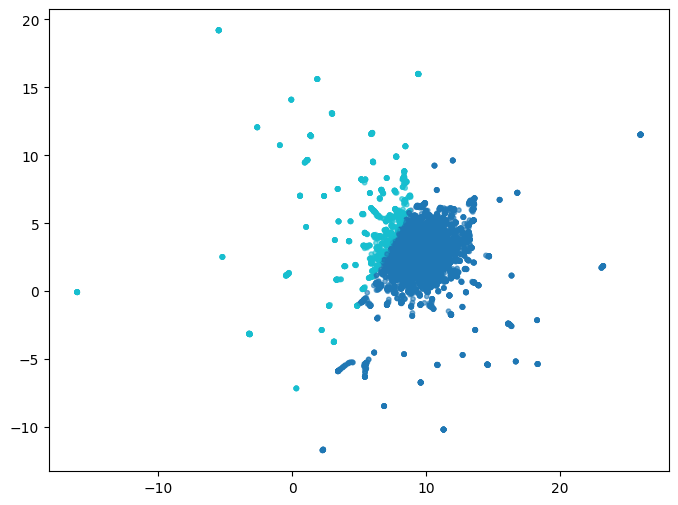

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED)
clusters_kmeans = kmeans.fit_predict(X_umap_direct_2d)

train_df['kmeans_cluster'] = clusters_kmeans

plt.figure(figsize=(8,6))
plt.scatter(
    X_umap_direct_2d[:, 0],
    X_umap_direct_2d[:, 1],
    c=clusters_kmeans,
    cmap='tab10',
    alpha=0.6,
    s=10
)

ct = pd.crosstab(train_df['kmeans_cluster'], train_df['target'], rownames=['Cluster'], colnames=['Target'])

# Asignar el cluster que más positivos tiene como el positivo
cluster_positive = ct.index[ct[1].argmax()]
preds = (clusters_kmeans == cluster_positive).astype(int)
f1 = f1_score(train_df['target'], preds)
print(f"\nF1 usando clusters como predicción: {f1:.4f}")


Matriz de confusión:
[[ 455 3887]
 [ 888 2383]]


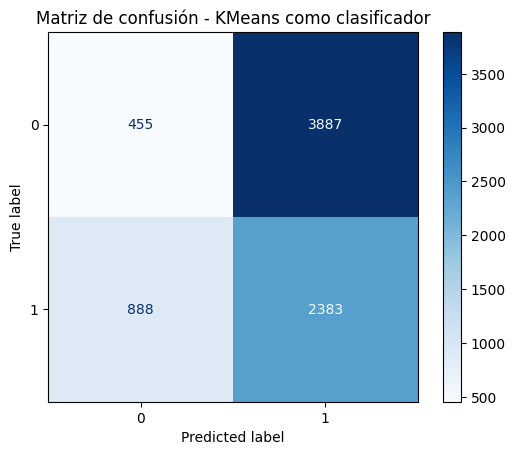

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(train_df['target'], preds)
print("Matriz de confusión:")
print(cm)

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - KMeans como clasificador")
plt.show()


Bueno, mi modelo es malísimo. Demasiados falsos positivos. Probemos con embeddings BERT, entiendo que captan semántica mejor que TF-IDF.

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

X_bert = model.encode(train_df['text'].fillna('').tolist(), show_progress_bar=True)

print(X_bert.shape)  

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

(7613, 384)


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=27, verbose=True)
Thu Nov 20 16:04:58 2025 Construct fuzzy simplicial set
Thu Nov 20 16:04:58 2025 Finding Nearest Neighbors
Thu Nov 20 16:04:58 2025 Building RP forest with 9 trees


/home/mate/FIUBA/ciencia-de-datos/tweet-checker/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Thu Nov 20 16:04:59 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Thu Nov 20 16:05:03 2025 Finished Nearest Neighbor Search
Thu Nov 20 16:05:03 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Nov 20 16:05:07 2025 Finished embedding


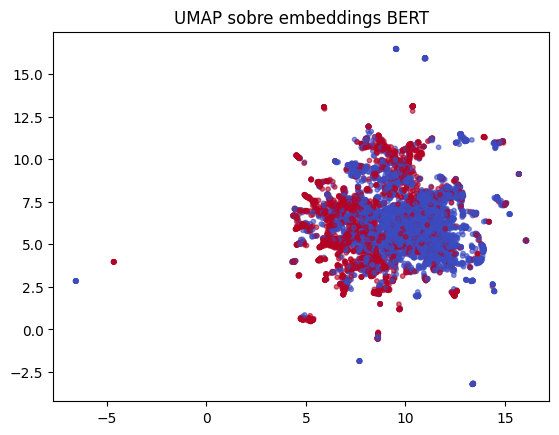

In [8]:
umap_bert = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=True
)

X_bert_umap = umap_bert.fit_transform(X_bert)

plt.scatter(X_bert_umap[:, 0], X_bert_umap[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.6)
plt.title("UMAP sobre embeddings BERT")
plt.show()

Seguimos viendo demasiada disperción. Clarísima dif entre derecha e izquierda, pero no hay clusters definidos. A ver si KMeans mejora...

Cluster asignado a clase positiva (target=1): 0
F1 usando KMeans sobre UMAP(BERT): 0.6196
Accuracy: 0.6737
Adjusted Rand Index (ARI): 0.1202

Matriz de confusión:
 [[3106 1236]
 [1248 2023]]


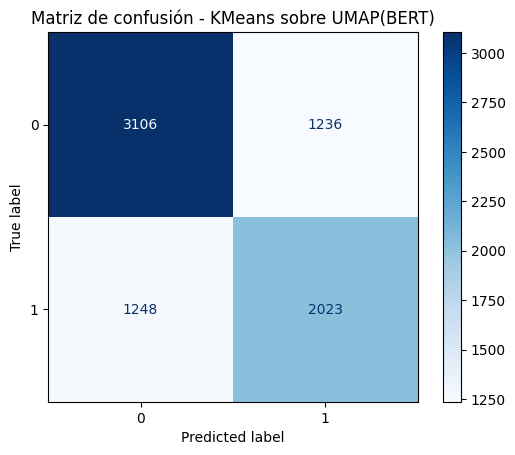

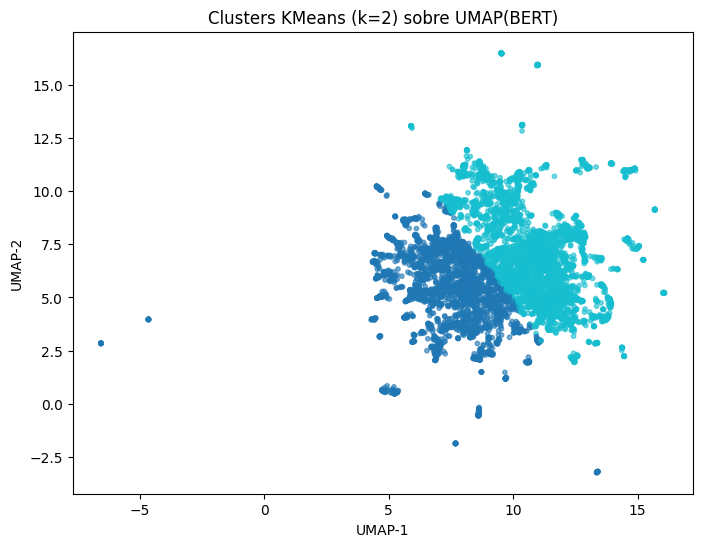

In [ ]:
from sklearn.metrics import accuracy_score

# K-Means 
kmeans_bert = KMeans(
    n_clusters=2,
    random_state=RANDOM_SEED,
    n_init=10
)
clusters_bert = kmeans_bert.fit_predict(X_bert_umap)

train_df["bert_umap_cluster"] = clusters_bert


## Problemón: Hay que asignar un cluster a la clase positiva (target=1) para poder evaluar las métricas de clasificación
ct = pd.crosstab(train_df["bert_umap_cluster"], y)

cluster_for_positive = ct[1].idxmax()
print(f"Cluster asignado a clase positiva (target=1): {cluster_for_positive}")

y_pred = (clusters_bert == cluster_for_positive).astype(int)

f1 = f1_score(y, y_pred)
acc = accuracy_score(y, y_pred)
ari = adjusted_rand_score(y, clusters_bert)

print(f"F1 usando KMeans sobre UMAP(BERT): {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Matriz de confusión 
cm = confusion_matrix(y, y_pred)
print("\nMatriz de confusión:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - KMeans sobre UMAP(BERT)")
plt.show()


# Visualización de clusters 
plt.figure(figsize=(8, 6))
plt.scatter(
    X_bert_umap[:, 0],
    X_bert_umap[:, 1],
    c=clusters_bert,
    cmap="tab10",
    s=10,
    alpha=0.6,
)
plt.title("Clusters KMeans (k=2) sobre UMAP(BERT)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


Bueno mucho mejor esta vez! Muchos menos falsos positivos. F1 de 0.67. Se ve que Bert ayudó bastante a la hora de encontrar relaciones semánticas entre las palabras de los tweets. Igyual sigue siendo un modelo malo, para la reducción de dimensionalidad que hicimos está bastante bien. Podríamos mejorar mucho más con un embedding mejor entrenado o con más datos. Pero bueno, la idea era ver si se podía hacer algo con el embedding TF-IDF y UMAP, y la respuesta es que sí, aunque no mejor que otros modelos.